In [1]:
# Import Dependencies 
from functools import reduce
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import quandl
import numpy as np
import pandas as pd
import time
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
from statsmodels.tsa.stattools import coint
from scipy import stats

# API keys
quandl.ApiConfig.api_key = 'n8ytM4yxbemwLYG_yrRa'

In [2]:
# Gather fundamentals
fundamentals = quandl.get_table("SHARADAR/TICKERS", paginate=True)
fundamentals

,table,permaticker,ticker,name,exchange,isdelisted,category,cusips,siccode,sicsector,...,currency,location,lastupdated,firstadded,firstpricedate,lastpricedate,firstquarter,lastquarter,secfilings,companysite
None,,,,,,,,,,,,,,,,,,,,,
0,SF1,196290,A,Agilent Technologies Inc,NYSE,N,Domestic,00846U101,3826.0,Manufacturing,...,USD,California; U.S.A,2019-12-20,2014-09-26,1999-11-18,2020-02-10,1997-06-30,2019-09-30,https://www.sec.gov/cgi-bin/browse-edgar?actio...,http://www.agilent.com
1,SF1,124392,AA,Alcoa Corp,NYSE,N,Domestic,013872106,3350.0,Manufacturing,...,USD,New York; U.S.A,2019-11-01,2016-11-01,2016-11-01,2020-02-10,2014-12-31,2019-09-30,https://www.sec.gov/cgi-bin/browse-edgar?actio...,http://www.alcoa.com
2,SF1,122827,AAAB,Admiralty Bancorp Inc,NASDAQ,Y,Domestic,007231103,6022.0,Finance Insurance And Real Estate,...,USD,Florida; U.S.A,2019-07-29,2017-09-09,1998-09-25,2003-01-28,1997-09-30,2002-09-30,https://www.sec.gov/cgi-bin/browse-edgar?actio...,None
3,SF1,120538,AAAGY,Altana Aktiengesellschaft,NYSE,Y,ADR,02143N103,2834.0,Manufacturing,...,EUR,Jordan,2019-05-17,2018-02-13,2002-05-22,2010-08-12,2000-12-31,2005-12-31,https://www.sec.gov/cgi-bin/browse-edgar?actio...,None
4,SF1,155760,AAAP,Advanced Accelerator Applications SA,NASDAQ,Y,ADR,00790T100,2834.0,Manufacturing,...,EUR,France,2019-08-30,2016-05-19,2015-11-11,2018-02-09,2012-12-31,2016-12-31,https://www.sec.gov/cgi-bin/browse-edgar?actio...,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36193,SFP,111633,^DJI,Dow Jones Industrial Average,INDEX,N,IDX,None,NaN,None,...,USD,None,2020-02-10,2019-02-03,1986-01-01,2020-02-10,None,None,None,None
36194,SFP,111631,^GSPC,S&P 500,INDEX,N,IDX,None,NaN,None,...,USD,None,2020-02-10,2019-02-03,1986-01-01,2020-02-10,None,None,None,None
36195,SFP,111632,^IXIC,NASDAQ Composite,INDEX,N,IDX,None,NaN,None,...,USD,None,2020-02-10,2019-02-03,1986-01-01,2020-02-10,None,None,None,None


In [3]:
# Select wanted columns | reset index | Drop Empty Rows | Delete Duplicates
fundamentals = fundamentals[['ticker','scalemarketcap', 'scalerevenue','siccode']]
fundamentals = fundamentals.reset_index()
fundamentals = fundamentals.dropna(axis=0, how='all', thresh=None, subset=None, inplace=False)
fundamentals = fundamentals.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

# Change Values into numbers only
fundamentals['scalemarketcap'] = fundamentals['scalemarketcap'].str[:2]
fundamentals['scalerevenue'] = fundamentals['scalerevenue'].str[:2]

# Turn into numeric float types
fundamentals['scalerevenue'] = fundamentals['scalerevenue'].astype(float)
fundamentals['scalemarketcap'] = fundamentals['scalemarketcap'].astype(float)

fundamentals = fundamentals.drop_duplicates(subset='ticker')
fundamentals


,None,ticker,scalemarketcap,scalerevenue,siccode
0,0,A,5.0,5.0,3826.0
1,1,AA,4.0,5.0,3350.0
2,2,AAAB,2.0,1.0,6022.0
3,3,AAAGY,4.0,4.0,2834.0
4,4,AAAP,3.0,2.0,2834.0
...,...,...,...,...,...
14528,14528,ZYME,3.0,2.0,2834.0
14529,14529,ZYNE,2.0,1.0,2834.0
14530,14530,ZYTO,1.0,1.0,3841.0
14531,14531,ZYXI,3.0,1.0,3845.0


In [5]:
# Get list of tickers in Fundamentals Table
ticker_list = fundamentals['ticker']
print("Tickers to query:", len(ticker_list))

Tickers to query: 13952


In [6]:
# Gather equity prices
dataframes_list = []
for stock in ticker_list:
    try:
        equity_prices = quandl.get(f'EOD/{stock}',start_date='2018-02-02', end_date='2020-02-02',paginate=True)
        equity_prices = equity_prices.iloc[:,:1]
        equity_prices = equity_prices.rename(columns={"Open": f"{stock}"})
        
        if equity_prices.shape[0] != 0:
            dataframes_list.append(equity_prices)

        else:
            pass
        

    except:
         continue
            
equity_prices = pd.concat(dataframes_list, axis=1)    
print('----------------Data Collection Done-------------------')

equity_prices

----------------Data Collection Done-------------------


,A,AA,AAAP,AAC,AACG,AAL,AAMC,AAME,AAN,AAOI,...,ZS,ZSAN,ZTO,ZTS,ZUMZ,ZUO,ZVO,ZYME,ZYNE,ZYXI
Date,,,,,,,,,,,,,,,,,,,,,
2018-02-02,72.32,52.00,80.49,8.56,4.8800,53.49,67.7000,3.60,40.53,33.61,...,NaN,6.31,16.090,77.53,20.80,NaN,7.79,13.1200,11.65,NaN
2018-02-05,70.86,48.61,80.66,8.01,4.8000,51.99,67.7000,3.50,38.71,32.50,...,NaN,5.63,15.160,76.64,20.45,NaN,7.49,12.8900,10.90,NaN
2018-02-06,66.96,47.44,80.75,7.96,4.8000,49.32,67.7000,3.35,36.67,32.00,...,NaN,4.84,14.710,72.74,20.10,NaN,7.02,12.1500,10.60,NaN
2018-02-07,68.19,49.23,81.30,8.26,5.9900,50.91,67.7000,3.35,38.37,33.86,...,NaN,4.66,15.450,72.70,20.55,NaN,7.35,12.0354,11.09,NaN
2018-02-08,68.09,47.81,81.68,8.13,6.0000,51.44,69.6500,3.30,39.49,31.30,...,NaN,4.60,15.120,73.96,20.40,NaN,7.20,12.0450,11.60,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-27,86.54,15.01,NaN,NaN,1.3400,26.57,12.8684,1.78,60.49,13.47,...,55.55,1.34,21.715,134.42,31.28,15.00,1.66,46.4200,5.18,9.86
2020-01-28,86.85,15.10,NaN,NaN,1.3253,26.36,13.3000,1.81,61.77,13.35,...,56.52,1.30,22.350,136.14,31.91,15.15,1.64,44.0400,5.26,9.94
2020-01-29,87.55,14.83,NaN,NaN,1.2100,26.88,13.3400,2.22,63.04,12.89,...,56.93,1.27,22.500,138.97,32.45,15.13,1.60,44.5400,5.18,10.57


In [7]:
# Clean Prices | Replace and drop Nas 
equity_prices = equity_prices.replace([np.inf, -np.inf], np.nan)
equity_prices = equity_prices.dropna(axis=1, how='all')
equity_prices = equity_prices.dropna(axis=1, how='any')
print("---Prices---")
equity_prices

---Prices---


,A,AA,AACG,AAL,AAMC,AAME,AAN,AAOI,AAON,AAP,...,ZKIN,ZLAB,ZNGA,ZNH,ZSAN,ZTO,ZTS,ZUMZ,ZYME,ZYNE
Date,,,,,,,,,,,,,,,,,,,,,
2018-02-02,72.32,52.00,4.8800,53.49,67.7000,3.60,40.53,33.61,35.95,115.92,...,8.90,26.30,3.68,64.70,6.31,16.090,77.53,20.80,13.1200,11.65
2018-02-05,70.86,48.61,4.8000,51.99,67.7000,3.50,38.71,32.50,35.40,113.05,...,8.34,25.83,3.55,67.94,5.63,15.160,76.64,20.45,12.8900,10.90
2018-02-06,66.96,47.44,4.8000,49.32,67.7000,3.35,36.67,32.00,33.40,108.28,...,7.11,25.19,3.46,63.20,4.84,14.710,72.74,20.10,12.1500,10.60
2018-02-07,68.19,49.23,5.9900,50.91,67.7000,3.35,38.37,33.86,33.55,112.09,...,7.27,23.00,3.60,60.75,4.66,15.450,72.70,20.55,12.0354,11.09
2018-02-08,68.09,47.81,6.0000,51.44,69.6500,3.30,39.49,31.30,33.70,109.93,...,7.71,22.50,3.85,60.00,4.60,15.120,73.96,20.40,12.0450,11.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-27,86.54,15.01,1.3400,26.57,12.8684,1.78,60.49,13.47,52.35,139.89,...,1.65,53.08,6.05,27.52,1.34,21.715,134.42,31.28,46.4200,5.18
2020-01-28,86.85,15.10,1.3253,26.36,13.3000,1.81,61.77,13.35,53.67,139.78,...,1.58,53.81,5.98,28.01,1.30,22.350,136.14,31.91,44.0400,5.26
2020-01-29,87.55,14.83,1.2100,26.88,13.3400,2.22,63.04,12.89,53.91,139.05,...,1.56,55.02,6.11,28.43,1.27,22.500,138.97,32.45,44.5400,5.18


In [9]:
# Convert prices into percentage change
equity_returns = equity_prices.pct_change()
equity_returns = equity_returns.iloc[1:]
print("---Returns---")
equity_returns

---Returns---


,A,AA,AACG,AAL,AAMC,AAME,AAN,AAOI,AAON,AAP,...,ZKIN,ZLAB,ZNGA,ZNH,ZSAN,ZTO,ZTS,ZUMZ,ZYME,ZYNE
Date,,,,,,,,,,,,,,,,,,,,,
2018-02-05,-0.020188,-0.065192,-0.016393,-0.028043,0.000000,-0.027778,-0.044905,-0.033026,-0.015299,-0.024758,...,-0.062921,-0.017871,-0.035326,0.050077,-0.107765,-0.057800,-0.011479,-0.016827,-0.017530,-0.064378
2018-02-06,-0.055038,-0.024069,0.000000,-0.051356,0.000000,-0.042857,-0.052700,-0.015385,-0.056497,-0.042194,...,-0.147482,-0.024777,-0.025352,-0.069767,-0.140320,-0.029683,-0.050887,-0.017115,-0.057409,-0.027523
2018-02-07,0.018369,0.037732,0.247917,0.032238,0.000000,0.000000,0.046359,0.058125,0.004491,0.035187,...,0.022504,-0.086939,0.040462,-0.038766,-0.037190,0.050306,-0.000550,0.022388,-0.009432,0.046226
2018-02-08,-0.001466,-0.028844,0.001669,0.010411,0.028804,-0.014925,0.029189,-0.075605,0.004471,-0.019270,...,0.060523,-0.021739,0.069444,-0.012346,-0.012876,-0.021359,0.017331,-0.007299,0.000798,0.045987
2018-02-09,-0.024820,-0.026563,-0.040000,-0.033826,-0.029433,-0.045455,-0.020765,0.028115,-0.007418,0.004184,...,0.025940,-0.101778,-0.085714,-0.075833,-0.093478,-0.007937,-0.023391,-0.012255,-0.002906,-0.025000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-27,-0.032532,-0.079141,-0.088373,-0.079029,-0.028800,-0.096447,-0.012086,-0.060014,-0.027855,-0.067400,...,-0.029412,-0.028551,-0.056162,-0.088742,-0.042857,-0.066824,-0.037244,-0.027968,0.023143,-0.078292
2020-01-28,0.003582,0.005996,-0.010970,-0.007904,0.033540,0.016854,0.021161,-0.008909,0.025215,-0.000786,...,-0.042424,0.013753,-0.011570,0.017805,-0.029851,0.029242,0.012796,0.020141,-0.051271,0.015444
2020-01-29,0.008060,-0.017881,-0.086999,0.019727,0.003008,0.226519,0.020560,-0.034457,0.004472,-0.005222,...,-0.012658,0.022487,0.021739,0.014995,-0.023077,0.006711,0.020787,0.016923,0.011353,-0.015209


In [10]:
# Select tickers Only in prices tables 
fundamentals_data = pd.DataFrame(equity_returns.columns[:], columns =['ticker'])
fundamentals = fundamentals_data.merge(fundamentals,on="ticker")
fundamentals = fundamentals.dropna(axis=0, how='any')
fundamentals = fundamentals.set_index('ticker')
print("Fundamentals Data")
fundamentals 

Fundamentals Data


,None,scalemarketcap,scalerevenue,siccode
ticker,,,,
A,0,5.0,5.0,3826.0
AA,1,4.0,5.0,3350.0
AACG,11,2.0,2.0,8200.0
AAL,18,5.0,5.0,4512.0
AAMC,19,4.0,3.0,6500.0
...,...,...,...,...
ZTO,14519,5.0,4.0,4210.0
ZTS,14520,5.0,4.0,2834.0
ZUMZ,14522,3.0,3.0,5600.0


In [111]:
N_PRIN_COMPONENTS = 50
pca = PCA(n_components=N_PRIN_COMPONENTS)
pca.fit(equity_returns)

PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [112]:
pca.components_.T.shape

(4051, 50)

In [113]:
X = np.hstack(
    (pca.components_.T,
     fundamentals['scalemarketcap'][equity_returns.columns].values[:, np.newaxis],
     fundamentals['scalerevenue'][equity_returns.columns].values[:, np.newaxis])
)

print(X.shape)

(4051, 52)


In [114]:
X = preprocessing.StandardScaler().fit_transform(X)
print(X.shape)

(4051, 52)


In [133]:
clf = DBSCAN(min_samples=10)
print(clf)

clf.fit(X)
labels = clf.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print("\nClusters discovered: %d" % n_clusters_)

clustered = clf.labels_

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=10, n_jobs=1, p=None)

Clusters discovered: 16


In [134]:
# the initial dimensionality of the search was
ticker_count = len(equity_returns.columns)
print("Total pairs possible in universe: %d " % (ticker_count*(ticker_count-1)/2))


Total pairs possible in universe: 8203275 


In [135]:
clustered_series = pd.Series(index=equity_returns.columns, data=clustered.flatten())
clustered_series_all = pd.Series(index=equity_returns.columns, data=clustered.flatten())
clustered_series = clustered_series[clustered_series != -1]

In [136]:
CLUSTER_SIZE_LIMIT = 200
counts = clustered_series.value_counts()
ticker_count_reduced = counts[(counts>1) & (counts<=CLUSTER_SIZE_LIMIT)]
print("Clusters formed: %d" % len(ticker_count_reduced))
print("Pairs to evaluate: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum())

Clusters formed: 10
Pairs to evaluate: 44528


In [137]:
X_tsne = TSNE(learning_rate=1000, perplexity=25, random_state=1337).fit_transform(X)

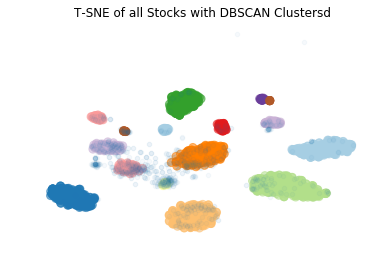

In [138]:
plt.figure(1, facecolor='white')
plt.clf()
plt.axis('off')

plt.scatter(
    X_tsne[(labels!=-1), 0],
    X_tsne[(labels!=-1), 1],
    s=65,
    alpha=0.55,
    c=labels[labels!=-1],
    cmap=cm.Paired
)

plt.scatter(
    X_tsne[(clustered_series_all==-1).values, 0],
    X_tsne[(clustered_series_all==-1).values, 1],
    s=20,
    alpha=0.04
)

plt.title('T-SNE of all Stocks with DBSCAN Clustersd');

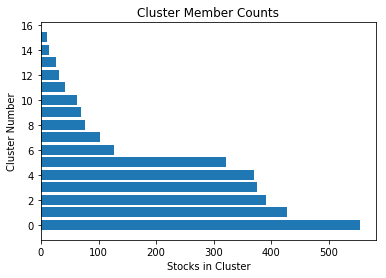

In [139]:
plt.barh(range(len(clustered_series.value_counts())),clustered_series.value_counts())
plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number');

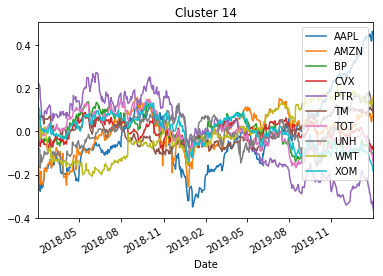

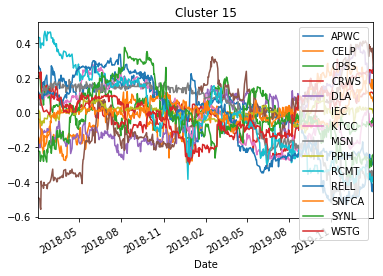

In [140]:
# get the number of stocks in each cluster
counts = clustered_series.value_counts()

# let's visualize some clusters
cluster_vis_list = list(counts[(counts<20) & (counts>1)].index)[::-1]

# plot a handful of the smallest clusters
for clust in cluster_vis_list[0:min(len(cluster_vis_list), 3)]:
    tickers = list(clustered_series[clustered_series==clust].index)
    means = np.log(equity_prices[tickers].mean())
    data = np.log(equity_prices[tickers]).sub(means)
    data.plot(title='Cluster %d' % clust)
    

In [141]:
which_cluster = clustered_series.loc[('UNH')]
clustered_series[clustered_series == which_cluster]

AAPL    14
AMZN    14
BP      14
CVX     14
PTR     14
TM      14
TOT     14
UNH     14
WMT     14
XOM     14
dtype: int64

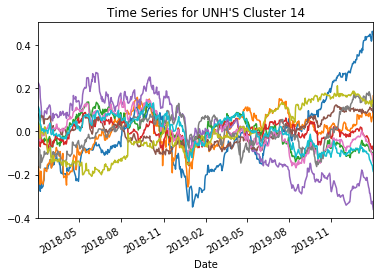

In [142]:

tickers = list(clustered_series[clustered_series==which_cluster].index)
means = np.log(equity_prices[tickers].mean())
data = np.log(equity_prices[tickers]).sub(means)
data.plot(legend=False, title="Time Series for UNH'S Cluster %d" % which_cluster);

In [143]:
# This function is www.quantopian.com
def find_cointegrated_pairs(data, significance=0.05):
    n = np.array(data.shape[1])
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < significance:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [144]:
cluster_dict = {}
for i, which_clust in enumerate(ticker_count_reduced.index):
    tickers = clustered_series[clustered_series == which_clust].index
    score_matrix, pvalue_matrix, pairs = find_cointegrated_pairs(
        equity_prices[tickers]
    )
    cluster_dict[which_clust] = {}
    cluster_dict[which_clust]['score_matrix'] = score_matrix
    cluster_dict[which_clust]['pvalue_matrix'] = pvalue_matrix
    cluster_dict[which_clust]['pairs'] = pairs

In [145]:
pairs = []
for clust in cluster_dict.keys():
    pairs.extend(cluster_dict[clust]['pairs'])

In [146]:
print("We found %d pairs." % len(pairs))

We found 2287 pairs.


In [147]:
print("Unique tickers %d unique tickers." % len(np.unique(pairs)))

Unique tickers 542 unique tickers.


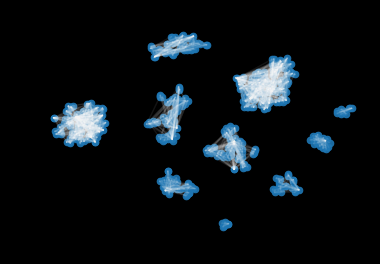

In [148]:
# Visualize T-SNE confirmed pairs
stocks = np.unique(pairs)
X_df = pd.DataFrame(index=equity_prices.T.index, data=X)
in_pairs_series = clustered_series.loc[stocks]
stocks = list(np.unique(pairs))
X_pairs = X_df.loc[stocks]

X_tsne = TSNE(learning_rate=50, perplexity=3, random_state=1337).fit_transform(X_pairs)

plt.figure(1, facecolor='black')
plt.clf()
plt.axis('off')
for pair in pairs:
    ticker1 = pair[0]
    loc1 = X_pairs.index.get_loc(pair[0])
    x1, y1 = X_tsne[loc1, :]

    ticker2 = pair[0]
    loc2 = X_pairs.index.get_loc(pair[1])
    x2, y2 = X_tsne[loc2, :]
      
    plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.08, c='white');
        
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=44, alpha=.9, cmap=cm.Paired)
plt.title('T-SNE Pairs');



In [157]:
pairs

[('ACNB', 'BCBP'),
 ('ACNB', 'CBFV'),
 ('ACNB', 'CLPR'),
 ('ACNB', 'FBIZ'),
 ('ACNB', 'FEIM'),
 ('ACNB', 'FSFG'),
 ('ACNB', 'ICBK'),
 ('ACNB', 'MPB'),
 ('ACNB', 'MTBC'),
 ('ACNB', 'PEBK'),
 ('ACNB', 'PFBI'),
 ('ACNB', 'QBAK'),
 ('ACNB', 'SBBX'),
 ('ACNB', 'SHBI'),
 ('ACNB', 'TCFC'),
 ('ACNB', 'UNAM'),
 ('ACU', 'FBIZ'),
 ('ACU', 'GRIF'),
 ('ACU', 'ITI'),
 ('ACU', 'NBN'),
 ('ACU', 'PKBK'),
 ('AEY', 'LUNA'),
 ('AEY', 'MAGS'),
 ('AINC', 'CLBS'),
 ('AINC', 'CLCT'),
 ('AINC', 'MAGS'),
 ('AINC', 'NHLD'),
 ('ARKR', 'BCRH'),
 ('ARKR', 'ESXB'),
 ('ARKR', 'EVBN'),
 ('ARKR', 'FONR'),
 ('ARKR', 'PFBI'),
 ('ARKR', 'SBBX'),
 ('ARKR', 'UNAM'),
 ('ASRV', 'BDL'),
 ('ASRV', 'BOCH'),
 ('ASRV', 'CFFI'),
 ('ASRV', 'CVLY'),
 ('ASRV', 'ISTR'),
 ('ASRV', 'NRIM'),
 ('ASRV', 'UNTY'),
 ('ASRV', 'VIRC'),
 ('BBQ', 'BCRH'),
 ('BBQ', 'EDUC'),
 ('BBQ', 'ESCA'),
 ('BBQ', 'FGBI'),
 ('BBQ', 'FONR'),
 ('BBQ', 'ICCH'),
 ('BBQ', 'QBAK'),
 ('BCBP', 'LCNB'),
 ('BCBP', 'NEN'),
 ('BCRH', 'CVU'),
 ('BCRH', 'FGBI'),
 ('BCRH', 'FO

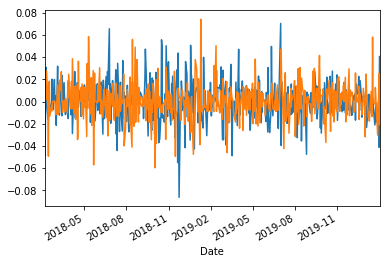

In [155]:

stock1 = pairs[1][0]
stock2 = pairs[1][1]
equity_returns[stock1].plot();
equity_returns[stock2].plot();

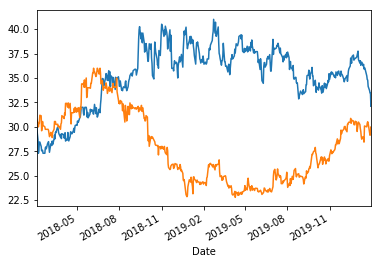

In [156]:
equity_prices[stock1].plot();
equity_prices[stock2].plot();